# The Multi-Armed Bandit problem



## Problem statement

> The multi-armed bandit problem models an agent that simultaneously attempts to acquire new knowledge (called "exploration") and optimize his or her decisions based on existing knowledge (called "exploitation"). The agent attempts to balance these competing tasks in order to maximize his total value over the period of time considered.

> The multi-armed bandit can be seen as a set of real distributions $B=\{R_{1},\dots ,R_{K}\}$, each distribution being associated with the rewards delivered by one of the $K \in \mathbb{N}^{+}$ levers. Let $\mu _{1},\dots ,\mu _{K}$ be the mean values associated with these reward distributions. The gambler iteratively plays one lever per round and observes the associated reward. The objective is to maximize the sum of the collected rewards. 
The regret $\rho$ after $T$ rounds is defined as the expected difference between the reward sum associated with an optimal strategy and the sum of the collected rewards: $\rho =T\mu ^{*}-\sum _{t=1}^{T}{\widehat {r}}_{t}$, where $\mu ^{*}$ is the maximal reward mean, $\mu ^{*}=\max _{k}\{\mu _{k}\}$, and ${\widehat {r}}_{t}$ is the reward in round t.

> [Wikipedia](https://en.wikipedia.org/wiki/Multi-armed_bandit])


The goal in this family of problems is to maximize the gain (or minimize the regret). The general strategy for these problems is "explore and exploit".  At each round of the experiment, the agent has the choice between using its current knowledge of the problem (exploiting) or trying something new (exploring) that might get better results.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

Each machine will use a Bernoulli distribution, meaning that it returns a positive reward (1) with a probability $q$, called the win rate, and a negative reward (0) with a probability $1-q$. Another option would be to use a Gaussian distribution to model the reward function, and to assign to each machine a different mean reward.

We define each machine with its win rate (the probability to outcome a positive reward, between 0 and 1). The class stores the number of pulls done with this machine, the current success rate $\frac{successes}{successes+failures}$(which should eventually equals the win rate) and exposes a method to pull the arm.

In [2]:
class BernoulliBandit:
    def __init__(self, win_rate):
        self.win_rate = win_rate
        self.pulls = 0
        self.success_rate = 0.0
        
    def pull(self):
        result = int(np.random.random() < self.win_rate)
        self.pulls += 1
        self.success_rate = self.success_rate + (float(result) - self.success_rate) / float(self.pulls)
        return result

We will first consider the case were $K=3$, meaning that we have 3 machines and 3 possible actions at each round. The first machine returns a positive reward with 30% probability, the second with 50% probability and the third one with 80% probability.

An experiment will consist in pulling an arm $N=10000$ times, and we will run $T=100$ experiments.

In [3]:
N = 10000            # number of pulls in each experiment
T = 100              # number of times we run an experiment

We instantiate all the machines and compute the expected ideal gain data.
The function `norm_regret` returns the normalized regret (between 0 and 1) of each steps of an experiment.

In [4]:
def init_bandits(win_rates):
    machines = [BernoulliBandit(q) for q in win_rates]
    best = np.arange(1, N+1) * np.max(win_rates)
    return machines, best

wr = [0.3, 0.5, 0.8]
bandits, optimal_gain = init_bandits(wr)

def norm_regret(gain):
    return (optimal_gain - gain) / optimal_gain

Let's define some utility functions.

In [5]:
def confidence_plot(mean, stderr, label):
    a, = plt.plot(mean, label=label)
    plt.fill_between(np.arange(N), mean-stderr, mean+stderr, facecolor=a.get_color(), alpha=0.15)
    plt.xscale('log')
    plt.ylim((0,1))
    plt.legend()
    plt.plot()


def run_experiments(iterations, draws, bandits, experiment):    
    regrets = np.empty((iterations+2, draws))
    srates = np.empty((iterations+2, len(bandits)))
    
    for iteration in range(iterations):
        gain = experiment(draws, bandits)
        regrets[iteration,:] = norm_regret(gain)
        srates[iteration,:] = [b.success_rate for b in bandits]

    regrets[iterations,:] = np.mean(regrets[:iterations,:], axis=0)
    regrets[iterations+1,:] = np.std(regrets[:iterations,:], axis=0)
    
    srates[iterations,:] = np.mean(srates[:iterations,:], axis=0)
    srates[iterations+1,:] = np.std(srates[:iterations,:], axis=0)
    
    return regrets, srates


def summary(regrets, srates, label):
    confidence_plot(regrets[-2,:], regrets[-1,:], label)
    print(label)
    print(f"  Average regret: {regrets[-2,-1]:0.3f} \xb1 {regrets[-1,-1]:0.3f} ")
    print(f"  Average success rates: {srates[-2,:]}")


## Random

The first and most naive strategy we can use for this problem is to pull any arm with the same probability.

In [6]:
def random_action(bandits):
    return np.random.choice(len(bandits))

def run_random(N, bandits):
    for b in bandits:
        b.pulls = 0
        b.success_rate = 0
        
    gain = np.empty(N)
        
    for iteration in range(N):
        index = random_action(bandits)
        gain[iteration] = bandits[index].pull()
    
    return np.cumsum(gain)

Running this strategy several times gives the following results:

In [7]:
r_rand, s_rand = run_experiments(T, N, bandits, run_random)

Random
  Average regret: 0.334 ± 0.006 
  Average success rates: [0.2992177  0.4987304  0.79961666]


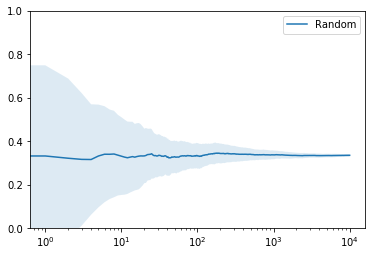

In [8]:
summary(r_rand, s_rand, "Random")

We observe that the final regret tends to about 0.333, which means that we have won on average 66% of the optimal gain.

Each machine arm has been pulled with the same probability of `1/K`. So the final gain can be approximated by `N*(0.3/3 + 0.5/3 + 0.8/3) = 5333`. The normalized regret is therefore `(8000 - 5333) / 8000 = 0.333`

This is a "full-explore" strategy, as we never leverage the knowledge we gather on the success rate of each machine, and this is never the optimal strategy.

## Greedy
In this strategy, the agent first pulls all the arms several times, then it selects the arm that returned the highest reward and always pulls this one.

In [9]:
def bestarm_action(bandits):
    return np.argmax([b.success_rate for b in bandits])

def run_greedy(init_draws, N, bandits):
    
    for b in bandits:
        b.pulls = 0
        b.success_rate = 0
        
    gain = np.empty(N)
    
    for iteration in range(init_draws * len(bandits)):
        gain[iteration] = bandits[iteration % len(bandits)].pull()
        
    for iteration in range(init_draws * len(bandits), N):
        index = bestarm_action(bandits)
        gain[iteration] = bandits[index].pull()
    
    return np.cumsum(gain)

In [10]:
r_g1,  s_g1 = run_experiments(T, N, bandits, lambda N,bandits: run_greedy(1, N, bandits))
r_g2,  s_g2 = run_experiments(T, N, bandits, lambda N,bandits: run_greedy(2, N, bandits))
r_g5,  s_g5 = run_experiments(T, N, bandits, lambda N,bandits: run_greedy(5, N, bandits))
r_g10,  s_g10 = run_experiments(T, N, bandits, lambda N,bandits: run_greedy(10, N, bandits))

1
  Average regret: 0.105 ± 0.221 
  Average success rates: [0.16439944 0.2321254  0.65099213]
2
  Average regret: 0.043 ± 0.131 
  Average success rates: [0.22154147 0.36998738 0.74669923]
5
  Average regret: 0.005 ± 0.038 
  Average success rates: [0.31169863 0.42098459 0.79582928]
10
  Average regret: 0.003 ± 0.006 
  Average success rates: [0.29212121 0.48060069 0.79882293]


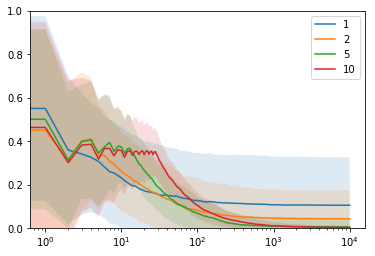

In [11]:
summary(r_g1,  s_g1, "1")
summary(r_g2,  s_g2, "2")
summary(r_g5,  s_g5, "5")
summary(r_g10,  s_g10, "10")

This strategy doesn't really encourage exploration, which means that the risk of selecting the wrong arm is high.

## Epsilon-greedy
Instead of exploiting the arm that gives the best reward in an initial exploration step, we will now choose to explore or exploit based on a probability. At each step, the agent will either choosing a random arm with a small probability $\epsilon$, or exploiting the most generous arm so far. Typically, we choose $\epsilon = 10\%$.

In [12]:
def run_epsilongreedy(eps, N, bandits):
    
    for b in bandits:
        b.pulls = 0
        b.success_rate = 0
        
    gain = np.empty(N)
        
    for iteration in range(N):
        
        p = np.random.random()
        if (p < eps):
            index = random_action(bandits)
        else:
            index = bestarm_action(bandits)
        
        gain[iteration] = bandits[index].pull()
    
    return np.cumsum(gain)

We try with different epsilon value to see how ot behaves.

In [13]:
r_eg10, s_eg10 = run_experiments(T, N, bandits, lambda N, bandits: run_epsilongreedy(0.1, N, bandits))
r_eg5, s_eg5 = run_experiments(T, N, bandits, lambda N, bandits: run_epsilongreedy(0.05, N, bandits))
r_eg1, s_eg1 = run_experiments(T, N, bandits, lambda N, bandits: run_epsilongreedy(0.01, N, bandits))

eps = 10%
  Average regret: 0.034 ± 0.006 
  Average success rates: [0.29885688 0.50119646 0.80063727]
eps = 5%
  Average regret: 0.022 ± 0.006 
  Average success rates: [0.30000605 0.49914001 0.80008344]
eps = 1%
  Average regret: 0.030 ± 0.039 
  Average success rates: [0.29610795 0.49988756 0.79983249]


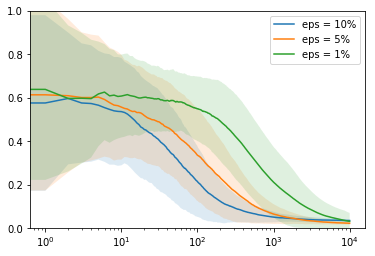

In [14]:
summary(r_eg10, s_eg10, "eps = 10%")
summary(r_eg5, s_eg5, "eps = 5%")
summary(r_eg1, s_eg1, "eps = 1%")

## Epsilon-decaying
In the epsilon-greedy algorithm, we use an epsilon value that won't change during the whole experiment. That means that we will always explore other solution with the same probabilty. But after many round, we have a more accurate estimation of the win rate distribution of the machine and we may want to reduce the exploration.

In this method, we start with a large $\epsilon$ and then decrease it throughout the whole experiment, so that the agent explore a lot at the beginning, and focus on the most generous machine in the end.

In [15]:
def run_epsilondecaying(N, bandits):
    
    for b in bandits:
        b.pulls = 0
        b.success_rate = 0
        
    gain = np.empty(N)
        
    for iteration in range(N):
        
        p = np.random.random()
        if (p < 0.1 * (1 - np.log10(iteration+1) / np.log10(N))):
            index = random_action(bandits)
        else:
            index = bestarm_action(bandits)
        
        gain[iteration] = bandits[index].pull()
    
    return np.cumsum(gain)

In [16]:
r_ed, s_ed = run_experiments(T, N, bandits, run_epsilondecaying)

epsilon-greedy
  Average regret: 0.034 ± 0.006 
  Average success rates: [0.29885688 0.50119646 0.80063727]
epsilon-decaying
  Average regret: 0.009 ± 0.009 
  Average success rates: [0.30141956 0.49236048 0.79933704]


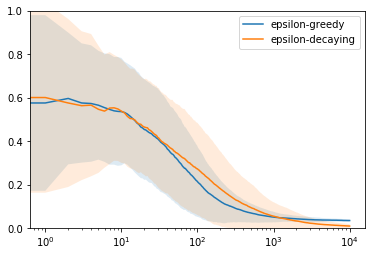

In [17]:
summary(r_eg10, s_eg10, "epsilon-greedy")
summary(r_ed, s_ed, "epsilon-decaying")

## Softmax-decaying
To go one step further, during the exploration, instead of choosing a random arm with a uniform distribution, we could choose with a higher probability the arm that has a higher reward. For this, we will use the softmax function:

$$\sigma :\mathbb {R} ^{K}\to (0,1)^{K}$$

$$\sigma (\mathbf {z} )_{j \in [1,K]}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}}$$

In [18]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_action(bandits):
    return np.random.choice(len(bandits), p=softmax([b.success_rate for b in bandits]))

def run_softmaxdecaying(N, bandits):
    
    for b in bandits:
        b.pulls = 0
        b.success_rate = 0
        
    gain = np.empty(N)
        
    for iteration in range(N):
        
        p = np.random.random()
        if (p < 0.1 * (1 - np.log10(iteration+1) / np.log10(N))):
            index = softmax_action(bandits)
        else:
            index = bestarm_action(bandits)
        
        gain[iteration] = bandits[index].pull()
    
    return np.cumsum(gain)

In [19]:
r_sm, s_sm = run_experiments(T, N, bandits, run_softmaxdecaying)

epsilon decaying
  Average regret: 0.009 ± 0.009 
  Average success rates: [0.30141956 0.49236048 0.79933704]
softmax decaying
  Average regret: 0.010 ± 0.010 
  Average success rates: [0.28729565 0.49028188 0.79963918]


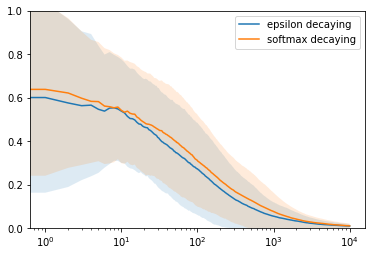

In [20]:
summary(r_ed, s_ed, "epsilon decaying")
summary(r_sm, s_sm, "softmax decaying")


## Optimistic Initial Values

Instead of using a probability to balance explore and exploit, this method initialize the success rate of each machine with very high value to force the exploration of these machines. Then, in the main loop, we always pull the machine with the highest success rate.

In [21]:
def run_optimisticinitialvalues(N, bandits):

    for b in bandits:
        b.pulls = 1
        b.success_rate = 10
        
    gain = np.empty(N)
        
    for iteration in range(N):
        index = bestarm_action(bandits)
        gain[iteration] = bandits[index].pull()
    
    return np.cumsum(gain)

Compare epsilon-greedy and optimistic initial values

In [22]:
r_oiv, s_oiv = run_experiments(T, N, bandits, run_optimisticinitialvalues)

Softmax-Decaying (eps=0.1)
  Average regret: 0.010 ± 0.010 
  Average success rates: [0.28729565 0.49028188 0.79963918]
Optimistic Initial Values
  Average regret: 0.002 ± 0.005 
  Average success rates: [0.77519401 0.78208571 0.80161073]


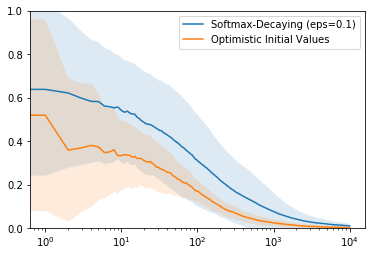

In [24]:
summary(r_sm, s_sm, "Softmax-Decaying (eps=0.1)")
summary(r_oiv, s_oiv, "Optimistic Initial Values")

## Upper Confidence Bound (UCB1)
This search algorithm is an extension of the Optimistic Initial Values algorithm. It takes into account the number of trials that have been made with a machine, and from that it estimates the trust we have in the accuracy of the computed success rate and adds an error term to this value. Instead of selecting the machine that has the highest success rate, we will select the machine that has the upper corrected value.

In [25]:
def compute_ucb(bandit, N):
    return bandit.success_rate + np.sqrt(2 * np.log(N+1) / (bandit.pulls + 0.001))

def ucb_action(bandits, N):
    return np.argmax([compute_ucb(b, N) for b in bandits])

def run_ucb1(N, bandits):
    for b in bandits:
        b.pulls = 1
        b.success_rate = 10
        
    gain = np.empty(N)
        
    for iteration in range(N):
        index = ucb_action(bandits, iteration)
        gain[iteration] = bandits[index].pull()
    
    return np.cumsum(gain)

In [26]:
r_ucb, s_ucb = run_experiments(T, N, bandits, run_ucb1)

Softmax-Decaying (eps=0.1)
  Average regret: 0.010 ± 0.010 
  Average success rates: [0.28729565 0.49028188 0.79963918]
Optimistic Initial Values
  Average regret: 0.002 ± 0.005 
  Average success rates: [0.77519401 0.78208571 0.80161073]
Upper Confidence Bound
  Average regret: 0.014 ± 0.005 
  Average success rates: [0.39397031 0.53968779 0.80023066]


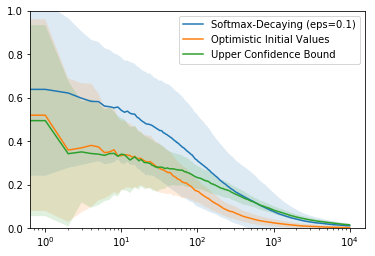

In [27]:
summary(r_sm, s_sm, "Softmax-Decaying (eps=0.1)")
summary(r_oiv, s_oiv, "Optimistic Initial Values")
summary(r_ucb, s_ucb, "Upper Confidence Bound")

## Thompson sampling

In the previous approaches, we estimated the win rates of each machine using a frequentist method, through the Maximum Likelihood Estimation (MLE) as follow:
$$\hat{q} = \frac{s}{s+f}$$
where:

- $\hat{q}$ is the estimation of the probability of a success with the Bernoulli distribution $P(X = 1) = q$, 
- $s$ is the number of successes
- $f$ is the number of failures.

This is not necessarily the best approach, particularly when we have very few samples. 

A better one is to estimate the value of $q$ that is the most probable given the numbers of success and failures observed so far:

$$\hat{q} = \underset {q \in [0,1]}{\operatorname {arg\,max} }\,\big(P(q \mid s,f)\big)$$

This is the Bayesian approach, which uses Bayesian inference according to Bayes' theorem:

$$P(H\mid E)={\frac {P(E\mid H)\cdot P(H)}{P(E)}}$$

where:

- $H$ stands for the _hypothesis_ whose probability may be affected by observed data (called evidence below). Often there are competing hypotheses, and the task is to determine which is the most probable.

- $E$ is the _evidence_ and corresponds to outcomes observed during the experiments.

- $P(H)$ is the _prior probability_, an estimate of the probability of the hypothesis $H$ before the data $E$ is observed.

- $P(H\mid E)$ is the _posterior probability_, that is the probability of $H$ once we know $E$ was observed. This is what we want to know: the probability of a hypothesis given the observed evidence.

- $P(E\mid H)$ is the _likelihood_, that is the probability of observing $E$ given $H$. It indicates the compatibility of the evidence with the given hypothesis.

- $P(E)$ is sometimes termed the _marginal likelihood_ or "model evidence". This factor is the same for all possible hypotheses being considered, so this factor is constant given $E$ and does not enter into determining the relative probabilities of different hypotheses.
 
In our case, and knowing the denominator is a constant over $q$ and that we only looking for the highest probability, we can just write this equation as a proportional relation:

$$P(q \mid s,f) \propto P(s,f \mid q)\cdot P(q)$$

The likelihood $P(s,f \mid q)$ represents the probability to observe $s$ successes and $f$ failures if we consider the probability of success $q$. To describe a series of $s+f$ independent draws of a Bernoulli distribution, we use the binomial distribution which gives us the probability of having $s$ success in $s+f$ attempts. It it represented as:

$$P(s,f \mid q) = {s+f \choose s}\,q^s\,(1-q)^f$$

The prior $P(q)$ represents an estimation of the probability that the machine was drawn by a Bernoulli distribution of probability $q$ without knowing the current data $s,f$. This distribution is called the _conjugate prior_, and in the case of the Bernoulli distribution, the conjugate prior is the Beta distribution:

$$\operatorname {Beta}(x; \alpha, \beta) = \frac{x^{\alpha-1}\,(1-x)^{\beta-1}}{\operatorname{B}(\alpha, \beta)}$$

where $\operatorname{B}(\alpha, \beta)$ is a normalization constant which ensures that the probability function integrates to 1.

If we substitute these two terms in the Bayes' equation:

$$
\begin{split}
P(q \mid s,f) & \propto P(s,f \mid q)                 \cdot P(q) \\
\\
              & \propto {s+f \choose s}\,q^s\,(1-q)^f \cdot \frac{q^{\alpha-1}\,(1-q)^{\beta-1}}{\operatorname{B}(\alpha, \beta)} \\
\\
              & \propto q^{s + \alpha - 1}\,(1-q)^{f + \beta - 1}
\end{split}
$$

So, we found out that the posterior is another Beta distribution with the parameters $(s + \alpha, f + \beta)$. This approach has the following advantage that we are going to have better estimates of the posterior when the number of successes and failures increases.

We initially suppose that the machine can have any win rate with the same probability, which is reasonable because we don't have any previous knowledge about the machine. This can be described by a uniform distribution, or by a Beta function with $\alpha = \beta = 1$.

In [28]:
def thompson_action(bandits):
    alpha = [1 + b.success_rate * b.pulls for b in bandits]
    beta = [1 + (1 - b.success_rate) * b.pulls for b in bandits]
    return np.argmax(np.random.beta(alpha, beta))


def run_thompson(N, bandits):
    for b in bandits:
        b.pulls = 0
        b.success_rate = 0
        
    gain = np.empty(N)
        
    for iteration in range(N):
        index = thompson_action(bandits)
        gain[iteration] = bandits[index].pull()
    
    return np.cumsum(gain)

In [29]:
r_th, s_th = run_experiments(T, N, bandits, run_thompson)

Softmax-Decaying (eps=0.1)
  Average regret: 0.010 ± 0.010 
  Average success rates: [0.28729565 0.49028188 0.79963918]
Optimistic Initial Values
  Average regret: 0.002 ± 0.005 
  Average success rates: [0.77519401 0.78208571 0.80161073]
Thompson Sampling
  Average regret: 0.001 ± 0.005 
  Average success rates: [0.26596812 0.45763573 0.8001845 ]


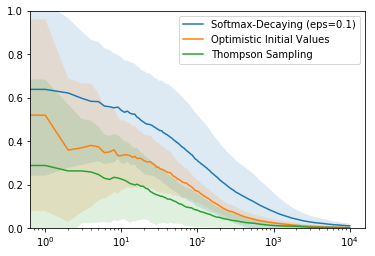

In [30]:
summary(r_sm, s_sm, "Softmax-Decaying (eps=0.1)")
summary(r_oiv, s_oiv, "Optimistic Initial Values")
summary(r_th, s_th, "Thompson Sampling")

Softmax-decaying
  Average regret: 0.019 ± 0.030 
  Average success rates: [0.69322452 0.36329781 0.56643508 0.08686593 0.76506173 0.03629603
 0.2057969  0.28432387 0.89621058 0.08057002]
Optimistic initial Values
  Average regret: 0.009 ± 0.004 
  Average success rates: [0.88832361 0.87395442 0.88436284 0.84883964 0.8925286  0.84103938
 0.8610817  0.87016239 0.90117732 0.84533059]
Thompson Sampling
  Average regret: 0.005 ± 0.004 
  Average success rates: [0.64237358 0.32407893 0.52848038 0.05914286 0.75492745 0.03902381
 0.13794643 0.23431663 0.89950208 0.06038095]


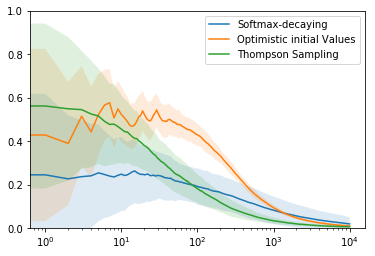

In [31]:
wr = [0.7, 0.4, 0.6, 0.1, 0.8, 0.05, 0.2, 0.3, 0.9, 0.1]
bandits, optimal_gain = init_bandits(wr)

r_sm,  s_sm  = run_experiments(T, N, bandits, run_softmaxdecaying)
r_oiv, s_oiv = run_experiments(T, N, bandits, run_optimisticinitialvalues)
r_th,  s_th  = run_experiments(T, N, bandits, run_thompson)

summary(r_sm, s_sm, "Softmax-decaying")
summary(r_oiv, s_oiv, "Optimistic initial Values")
summary(r_th, s_th, "Thompson Sampling")